In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# funkcja akceptująca ruch w przestrzeni portfela
def accept_move(current_sharpe, new_sharpe, temperature):
    if new_sharpe > current_sharpe:
        return True
    else:
        probability = np.exp((new_sharpe - current_sharpe) / temperature)
        return np.random.rand() < probability

# Funkcja obliczająca wskaźnik Sharpe'a
def calculate_sharpe(weights, expected_returns, covariance_matrix, risk_free_rate=0):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_risk = np.sqrt(np.dot(weights, np.dot(covariance_matrix, weights)))
    return (portfolio_return - risk_free_rate) / portfolio_risk

# Funkcja wykonująca losowy ruch w przestrzeni portfela (zmienia wagi aktywów)
def make_move(weights, min_weight=0.0, max_weight=1.0):
    new_weights = np.copy(weights)
    random_idx = random.randint(0, len(weights) - 1)
    change = np.random.uniform(-0.05, 0.05)  # Zmienność - losowa zmiana wagi
    new_weights[random_idx] += change
    # Zapewniamy, że suma wag jest równa 1 (portfel jest zrównoważony)
    new_weights = np.clip(new_weights, min_weight, max_weight)
    new_weights /= np.sum(new_weights)  # Normalizacja wag
    return new_weights

def make_move(portfolio, min_allocation, max_allocation):
    new_portfolio = portfolio + np.random.uniform(-0.01, 0.01, size=len(portfolio))
    return np.clip(new_portfolio, min_allocation, max_allocation)

In [ ]:
def simulated_annealing_portfolio(
        assets, expected_returns, covariance_matrix, 
        risk_free_rate=0, max_iter=1000, initial_temperature=100, 
        cooling_rate=0.99, max_allocation=0.25, min_allocation=0.0):
    num_assets = len(assets)
    current_portfolio = np.random.dirichlet(np.ones(num_assets))
    current_portfolio = enforce_constraints(current_portfolio, min_allocation, max_allocation)
    current_sharpe = calculate_sharpe(current_portfolio, expected_returns, covariance_matrix, risk_free_rate)
    best_portfolio = current_portfolio
    best_sharpe = current_sharpe
    temperature = initial_temperature

    for _ in range(max_iter):
        new_portfolio = make_move(current_portfolio, min_allocation, max_allocation)
        new_portfolio = enforce_constraints(new_portfolio, min_allocation, max_allocation)
        new_sharpe = calculate_sharpe(new_portfolio, expected_returns, covariance_matrix, risk_free_rate)
        if accept_move(current_sharpe, new_sharpe, temperature):
            current_portfolio = new_portfolio
            current_sharpe = new_sharpe
        if new_sharpe > best_sharpe:
            best_portfolio = new_portfolio
            best_sharpe = new_sharpe
        temperature *= cooling_rate

    return best_portfolio, best_sharpe


def enforce_constraints(portfolio, min_allocation, max_allocation):
    # Ensure all allocations are within min/max limits
    portfolio = np.clip(portfolio, min_allocation, max_allocation)
    
    # Rebalance to ensure allocations sum to 1
    if np.sum(portfolio) > 0:
        portfolio /= np.sum(portfolio)
    
    # Ensure no asset exceeds max allocation (25%)
    portfolio = np.clip(portfolio, 0, max_allocation)
    
    return portfolio

Wczytywanie danych z pliku: asset_data.csv

Oczekiwane roczne zwroty:
 AAPL     0.126567
AMZN     0.118165
GOOGL    0.120034
MSFT     0.137854
dtype: float64

Macierz kowariancji (roczna):
            AAPL      AMZN     GOOGL      MSFT
AAPL   0.076213  0.060800  0.057425  0.052817
AMZN   0.060800  0.149093  0.082604  0.073652
GOOGL  0.057425  0.082604  0.107015  0.064200
MSFT   0.052817  0.073652  0.064200  0.077166

Optymalizacja portfela...

Optymalny portfel:
AAPL: 26.20%
AMZN: 21.41%
GOOGL: 26.20%
MSFT: 26.20%

Optymalny wskaźnik Sharpe'a: 0.3924


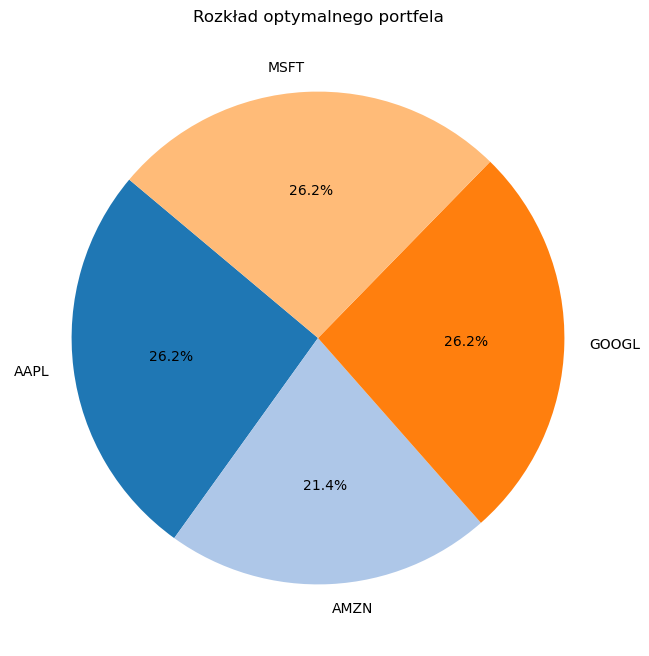

In [9]:

# Load data
filename = "asset_data.csv"
print(f"Wczytywanie danych z pliku: {filename}")
data = pd.read_csv(filename, index_col=0, parse_dates=True)

# Calculate returns, expected returns, and covariance matrix
returns = data.pct_change().dropna()
expected_returns = returns.mean() * 252  # Annualized
covariance_matrix = returns.cov() * 252  # Annualized

print("\nOczekiwane roczne zwroty:\n", expected_returns)
print("\nMacierz kowariancji (roczna):\n", covariance_matrix)

# Get asset names
tickers = data.columns
print("\nOptymalizacja portfela...")

# Perform optimization
optimal_portfolio, optimal_sharpe = simulated_annealing_portfolio(
    assets=tickers,
    expected_returns=expected_returns.values,
    covariance_matrix=covariance_matrix.values,
    risk_free_rate=0.02,
    max_iter=1000,
    initial_temperature=100,
    cooling_rate=0.95,
    max_allocation=0.25
)

# Print optimal portfolio allocation
print("\nOptymalny portfel:")
for ticker, allocation in zip(tickers, optimal_portfolio):
    print(f"{ticker}: {allocation:.2%}")
print(f"\nOptymalny wskaźnik Sharpe'a: {optimal_sharpe:.4f}")

# Plot portfolio allocation as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    optimal_portfolio,
    labels=tickers,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab20.colors
)
plt.title("Rozkład optymalnego portfela")
plt.show()